In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import spacy
from tqdm import tqdm
%matplotlib inline


In [2]:
nlp = spacy.load('en_core_web_lg',disable=["ner","tagger"])

In [3]:
doc=nlp('This is another doc. And this is another one.')

In [9]:
list(doc.sents)

[This is another doc., And this is another one.]

In [11]:
type(doc.sents)

generator

In [15]:
[x.lemma_ for x in doc]

['This',
 'be',
 'another',
 'doc',
 '.',
 'And',
 'this',
 'be',
 'another',
 'one',
 '.']

In [3]:
DATA_RAW_IN='/home/kvassay/data/z/data/reviews_raw.txt'
ENCODING='iso-8859-1'
DATASET_OUT='/home/kvassay/data/z/data/reviews_train_test_dev1.pickle'


In [4]:
def parse_line(line):
    splitted_line=line.split(':')
    return {splitted_line[0]:':'.join(splitted_line[1:]).strip()}

def read_dataset(path):
    records=[]
    with open(path, 'rb') as f:
        current_record={}
        first=True
        iteration=0
        for x in f.readlines():
            line=x.decode(ENCODING)
            if line.startswith('product/'):
                if not first:
                    records.append(current_record)
                first=False
                current_record=parse_line(line)
                current_record['review_id']=iteration
                iteration+=1
                continue
            if line.startswith('review/'):
                current_record.update(parse_line(line))
    return pd.DataFrame(records)

def normalize_data(df):
    df['score']=df['review/score'].astype(float)
    df['summary']=df['review/summary']
    df['text']=df['review/text']
    df['text']=df['text'].str.replace('<br />','\n\n')
    df.drop(df.columns.difference(['review_id','score','summary','text']), 1, inplace=True)
    return df
    
    
def train_dev_test_split(df,dev_train_size=0.2):
    train, x =train_test_split(df, test_size=dev_train_size,shuffle=True)
    dev, test = train_test_split(x, test_size=0.5,shuffle=True)
    return train,dev,test

In [5]:
df=read_dataset(DATA_RAW_IN)
df=normalize_data(df)

#### NLP analysis

In [7]:
%%time
tqdm.pandas(desc="SpaCy NLP analysis - Text",)
df['nlp_text']=df['text'].progress_apply(nlp)

SpaCy NLP analysis - Text: 100%|██████████| 568453/568453 [59:55<00:00, 158.09it/s]  

CPU times: user 59min 59s, sys: 19.1 s, total: 1h 18s
Wall time: 59min 55s


In [8]:
%%time
tqdm.pandas(desc="SpaCy NLP analysis - Summary",)
df['nlp_summary']=df['summary'].progress_apply(nlp,'tqdm_notebook')

SpaCy NLP analysis - Summary: 100%|██████████| 568453/568453 [22:28<00:00, 421.51it/s]

CPU times: user 22min 29s, sys: 10.3 s, total: 22min 40s
Wall time: 22min 28s


#### Train/Dev/Test split

In [9]:
train,dev,test=train_dev_test_split(df,dev_train_size=0.03)
train.head(2)

,review_id,score,summary,text,nlp_text,nlp_summary
568252,568252,5.0,The best Stevia sweetener! NO FUNKY AFTERTASTE!!!,"I've tried for years and years to like stevia,...","(I, 've, tried, for, years, and, years, to, li...","(The, best, Stevia, sweetener, !, NO, FUNKY, A..."
311884,311884,5.0,Awesome Candy from Paris,I recently bought a bag of Michoko Carmel Cand...,"(I, recently, bought, a, bag, of, Michoko, Car...","(Awesome, Candy, from, Paris)"


#### Train label balance

5.0    352178
4.0     78247
1.0     50743
3.0     41357
2.0     28874
Name: score, dtype: int64


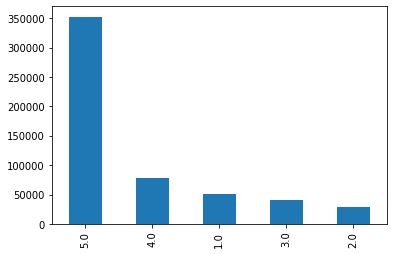

In [10]:
print(train['score'].value_counts())
train['score'].value_counts().plot.bar()

#### Dev label balance

5.0    5485
4.0    1193
1.0     767
3.0     648
2.0     434
Name: score, dtype: int64


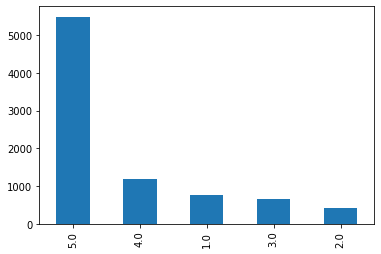

In [11]:
print(dev['score'].value_counts())
dev['score'].value_counts().plot.bar()

#### Test label balance

5.0    5458
4.0    1215
1.0     758
3.0     635
2.0     461
Name: score, dtype: int64


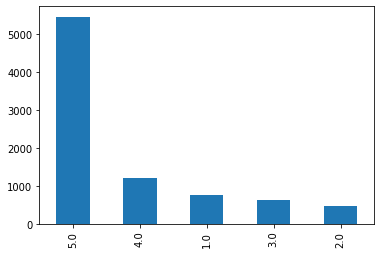

In [12]:
print(test['score'].value_counts())
test['score'].value_counts().plot.bar()

## Persist

In [13]:
%%time
with open(DATASET_OUT,'wb') as f:
    pickle.dump((train.to_dict(orient='records'), dev.to_dict(orient='records'), test.to_dict(orient='records')), f)